In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
thrustFromFile = np.genfromtxt('./AeroTech_L1520T.csv',delimiter=',')

In [3]:
thrust = np.insert(thrustFromFile,0,[0,0],axis=0)

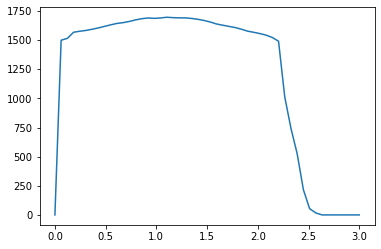

In [4]:
plt.plot(np.linspace(0,3),np.interp(np.linspace(0,3),thrust[:,0],thrust[:,1]));

In [5]:
#returns thrust force given a certain time in Newtons (N)
def thrustFunc(t):
    return np.interp(t,thrust[:,0],thrust[:,1])

#returns an approximation for the density of air at a given altitutde
def rho(altitude):
    rho0 = 1.225 #kg/m^3
    Hn = 10.4*10**3 #meters
    return rho0*np.exp(-altitude/Hn)

In [6]:
dt=0.001
tInitial = 0
tFinal = 60
time = np.arange(tInitial,tFinal,dt)

In [7]:
mass = 20 #kg
gravityForce = np.array([0,0,-9.81])*mass
Area = 0.0232
parachuteDragCoefficient = 10

In [8]:
initialVel = 150
targetAlt = 1100
def velocityProfile(alt):
    return initialVel/np.sqrt(targetAlt)*np.sqrt(targetAlt-alt)

altitudes = np.linspace(0,targetAlt,100)

velocityLookupTable = np.array([altitudes,velocityProfile(altitudes)])

In [38]:
def calculateError(position,velocity):
    altitude = position[2]
    velocityError = velocity[2] - np.interp(altitude, velocityLookupTable[0],velocityLookupTable[1])
    if(velocityError < 0):
        velocityError = 0
    return velocityError

maxError = 20
controlPeriod = 100
airbrakesMaxDrag = 0.2

In [39]:
positions = np.zeros((len(time),3)); # x,y,z
velocities = np.zeros((len(time),3)); # vx,vy,vz
accelerations = np.zeros((len(time),3)); #ax,ay,az
dragCoefficient  = np.full((len(time)),.4);

for i in range(len(time)-1):
    #determine which way the rocket is pointing
    direction = velocities[i]/(np.linalg.norm(velocities[i])+10**-9)
    
    #if on rail, launch angle is set
    if(positions[i,2]<1):
        direction = np.array([0,np.sin(0.0873),np.cos(0.0873)])
    
    sumForces = gravityForce + (thrustFunc(time[i]) - 1/2*Area*rho(positions[i,2])*np.linalg.norm(velocities[i])**2*dragCoefficient[i])*direction
    
    #ends simulation when rocket hits ground
    if (positions[i,2]<=0) and (time[i]>1):
        break
    
    #deploy parachute when rocket hits apogee
    if (velocities[i,2]<=0) and (time[i]>1):
        dragCoefficient[i:] = parachuteDragCoefficient
    
    #control algorithim, evaluate periodically (250 ticks or 250 m/s)
    if(i%controlPeriod==0):
        error = calculateError(positions[i],velocities[i])
        if error>maxError:
            error = maxError
        dragCoefficient[i:i+controlPeriod] = dragCoefficient[i:i+controlPeriod]+error/maxError*airbrakesMaxDrag
    
    accelerations[i] = sumForces/mass
    velocities[i+1] = accelerations[i]*dt + velocities[i]
    positions[i+1] = velocities[i]*dt + positions[i]

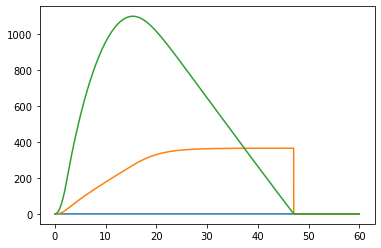

In [40]:
plt.plot(time,positions);

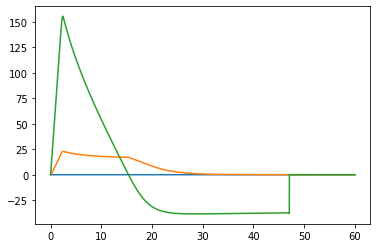

In [41]:
plt.plot(time,velocities);

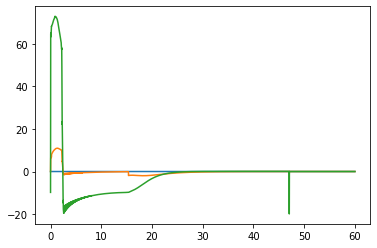

In [42]:
plt.plot(time,accelerations);

Text(0, 0.5, 'velocities (m/s)')

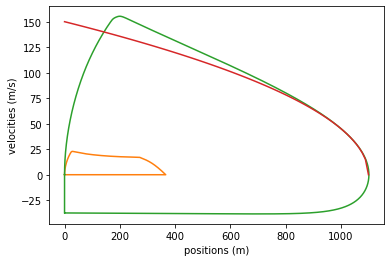

In [43]:
plt.plot(positions,velocities);
plt.plot(velocityLookupTable[0],velocityLookupTable[1])
plt.xlabel('positions (m)')
plt.ylabel('velocities (m/s)')

Text(0, 0.5, 'DragCoefficient')

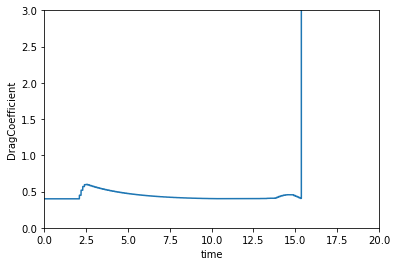

In [44]:
plt.plot(time,dragCoefficient);
plt.ylim([0,3]);
plt.xlim([0,20]);
plt.xlabel('time')
plt.ylabel('DragCoefficient')